# D-separation tutorial

We start with some imports and some useful functions that plot the graphs and check if they are blocked:

In [462]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain, combinations


def generateRandomDAG(num_nodes, prob_edge):
    # Generate random graph and make it become a DAG:
    G = nx.gnp_random_graph(num_nodes, prob_edge, directed = True)
    return nx.DiGraph([(u,v) for (u,v) in G.edges() if u<v])

def plotGraphWithColors(D,x,y,z, edge_colors='black'):
    color_map = []
    for node in D:
        if node not in x and node not in y and node not in z:
            color_map.append('w')
        elif node not in z: 
            color_map.append('r')  
        else: 
            color_map.append('g')
    nx.draw_shell(D, node_color=color_map, with_labels=True, edgecolors = "black", edge_color=edge_colors)
    

def plotGraphWithUnblockedPaths(D,x,y,z):
    for path in nx.all_simple_paths(D.to_undirected(), source=x[0], target=y[0]):
        blocked = is_blocked(G=D, path=path,conditioned_nodes=z)
        if not blocked:
            edge_colors = []
            path_couples = []
            for i in range(len(path)-1):
                src_node = path[i]
                targ_node = path[i+1]
                path_couples.append((src_node,targ_node))
                path_couples.append((targ_node,src_node))
            for (u, v) in D.edges():
                if (u,v) in path_couples:
                    edge_colors.append('r')
                else:
                    edge_colors.append('black')
            plotGraphWithColors(D,x,y,z,edge_colors)
            plt.show()
            
# This function is from the itertools page:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
    
### The function below is a slight modification of the same function in dowhy.causal_graph.py (there is a lot of other things that are unnecessary for us, so I copy it here:
def is_blocked(G, path, conditioned_nodes):
        """ Uses d-separation criteria to decide if conditioned_nodes block given path.
        """
        blocked_by_conditioning = False
        has_unconditioned_collider = False

        for i in range(len(path)-2):
            if G.has_edge(path[i], path[i+1]) and G.has_edge(path[i+2], path[i+1]): # collider
                collider_descendants = nx.descendants(G, path[i+1])
                if path[i+1] not in conditioned_nodes and all(cdesc not in conditioned_nodes for cdesc in collider_descendants):
                    has_unconditioned_collider=True
                    # print("Collider or its descendants are conditioned upon", path[i+1], collider_descendants, conditioned_nodes)
            else: # chain or fork
                if path[i+1] in conditioned_nodes:
                    blocked_by_conditioning = True
                    break
        if blocked_by_conditioning:
            return True
        elif has_unconditioned_collider:
            return True
        else:
            return False
        
def is_dsep_by_subset(D, x, y, z):
    dsep_subsets = []
    for cond in powerset(set(z)):
        c = []
        for c1 in cond:
            c.append(c1)
        if nx.algorithms.d_separated(D, set(x), set(y), set(c)):
            dsep_subsets.append(c)
    return dsep_subsets

def is_dsep_by_removing_at_most_k_nodes (D, x, y, z, k=1):
    if nx.algorithms.d_separated(D, set(x), set(y), set(z)):
        return True
    else: 
        for dsep_subset in is_dsep_by_subset(D, x, y, z):
            if len(dsep_subset) >= len(z) - k:
                return True
        return False

def is_dsep_by_adding_nodes (D, x, y, z):
    if nx.algorithms.d_separated(D, set(x), set(y), set(z)):
        return z
    else: 
        other_nodes = []
        for n in D.nodes():
            if n != x[0] and n != y[0] and n not in z:
                other_nodes.append(n)
        dsep_subsets = []
        for cond in powerset(other_nodes):
            c = []
            for z1 in z:
                c.append(z1)
            for c1 in cond:
                c.append(c1)
            if nx.algorithms.d_separated(D, set(x), set(y), set(c)):
                dsep_subsets.append(c)
        return dsep_subsets
    
def is_dsep_by_adding_at_most_k_nodes (D, x, y, z, k=1):
    if nx.algorithms.d_separated(D, set(x), set(y), set(z)):
        return True
    else: 
        for dsep_subset in is_dsep_by_adding_nodes(D, x, y, z):
            if len(dsep_subset) <= len(z) + k:
                return True
        return False    

## Level 1: Randomly select two variables and check if they are d-separated on a small graph:

Let's generate a random graph with num_nodes=6 and probability of having an edge 0.6. We then prune the edges that make it cyclic, ensuring we have a DAG.

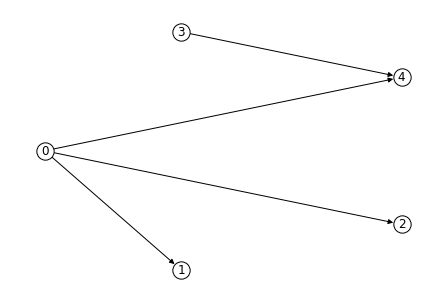

In [466]:
num_nodes = 5
D = generateRandomDAG(num_nodes, prob_edge=0.6)
nx.draw_shell(D, with_labels=True, node_color='w', edgecolors ='black')

Now, we select randomly two nodes that we want to test d-separation for (which will be show in red) and a conditioning set (which will be show in blue):

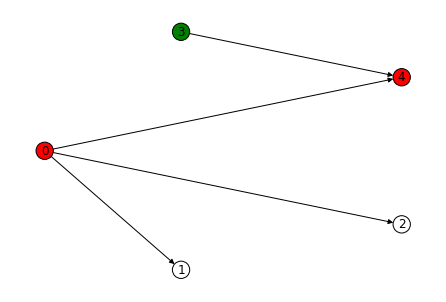

In [467]:
possible_nodes = list(range(num_nodes))

x = [np.random.choice(possible_nodes)]
possible_nodes.remove(x[0])

y = [np.random.choice(possible_nodes)]
possible_nodes.remove(y[0])

cond_size = np.random.randint(num_nodes-2)
z = list(np.random.choice(possible_nodes, cond_size, replace=False))

plotGraphWithColors(D,x,y,z)

Are these two red nodes d-separated given the blue ones? Try on your own before looking at the right answer:

In [468]:
print(x, "_|_", y, "|", z, ":", nx.algorithms.d_separated(D, set(x), set(y), set(z)))

[0] _|_ [4] | [3] : False


To help you understand better, we plot the unblocked paths one by one and color them in red:

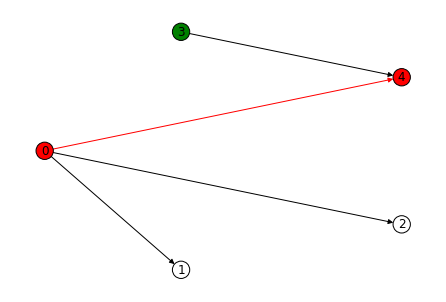

In [469]:
plotGraphWithUnblockedPaths(D,x,y,z)

Can you have a d-separation if you remove at most k nodes?

In [470]:
is_dsep_by_removing_at_most_k_nodes (D, x, y, z, k=1)

False

Can you have a d-separation if you add to z at most k nodes?

In [471]:
is_dsep_by_adding_at_most_k_nodes (D, x, y, z, k=1)


False

### Level 2: Randomly selecting a non-adjacent pair on a small random graph:

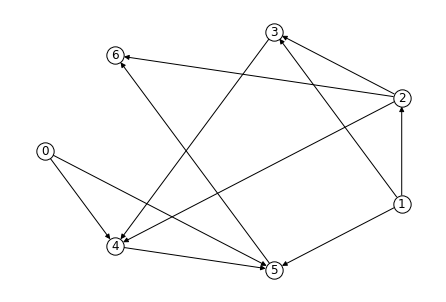

In [473]:
num_nodes = 7
D = generateRandomDAG(num_nodes, prob_edge=0.6)
nx.draw_shell(D, with_labels=True, node_color='w', edgecolors ='black')

Let's try now to force the algorithm to randomly choose a non-adjacent pair of variables to test d-separation on:

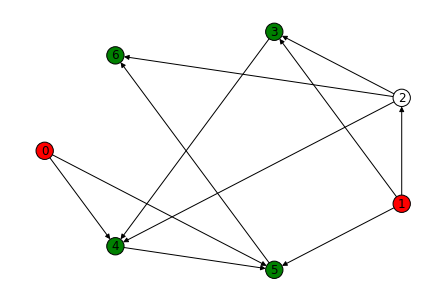

In [474]:
x = [np.random.randint(num_nodes)]

non_adj_nodes = list(range(num_nodes))
for (u,v) in D.edges():
    if u == x[0] or v == x[0]:
        if u in non_adj_nodes:
            non_adj_nodes.remove(u)
        if v in non_adj_nodes:
            non_adj_nodes.remove(v)
        
y = [np.random.choice(non_adj_nodes)]

possible_nodes = list(range(num_nodes))
possible_nodes.remove(x[0])
possible_nodes.remove(y[0])
cond_size = np.random.randint(num_nodes-2)
z = list(np.random.choice(possible_nodes, cond_size, replace=False))

plotGraphWithColors(D,x,y,z)

[0] _|_ [1] | [3, 6, 5, 4] : False


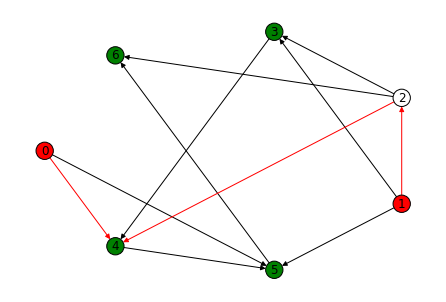

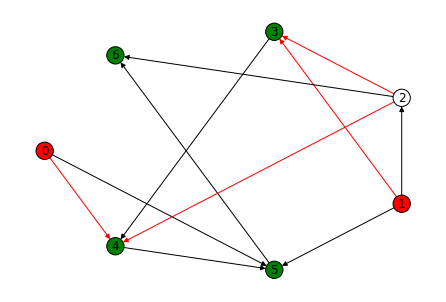

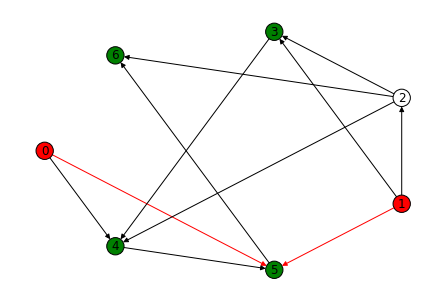

In [475]:
print(x, "_|_", y, "|", z, ":", nx.algorithms.d_separated(D, set(x), set(y), set(z)))
plotGraphWithUnblockedPaths(D,x,y,z)

In [476]:
is_dsep_by_adding_at_most_k_nodes (D, x, y, z, k=1)

False

In [477]:
is_dsep_by_removing_at_most_k_nodes (D, x, y, z, k=2)

False

## Level 3: Non-adjacent vertices in a medium random graph

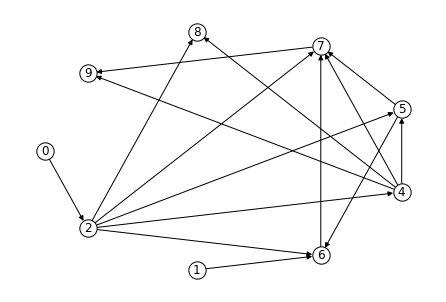

In [478]:
num_nodes = 10
D = generateRandomDAG(num_nodes, prob_edge=0.4)
nx.draw_shell(D, with_labels=True, node_color='w', edgecolors ='black')

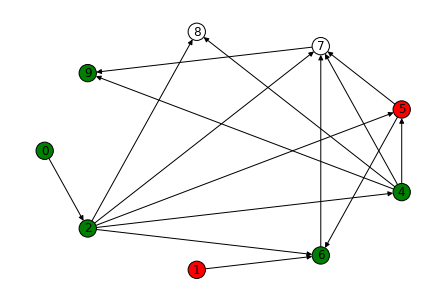

In [479]:
x = [np.random.randint(num_nodes)]

non_adj_nodes = list(range(num_nodes))
for (u,v) in D.edges():
    if u == x[0] or v == x[0]:
        if u in non_adj_nodes:
            non_adj_nodes.remove(u)
        if v in non_adj_nodes:
            non_adj_nodes.remove(v)
        
y = [np.random.choice(non_adj_nodes)]

possible_nodes = list(range(num_nodes))
possible_nodes.remove(x[0])
possible_nodes.remove(y[0])
cond_size = np.random.randint(num_nodes-2)
z = list(np.random.choice(possible_nodes, cond_size, replace=False))

plotGraphWithColors(D,x,y,z)

[5] _|_ [1] | [9, 0, 4, 2, 6] : False


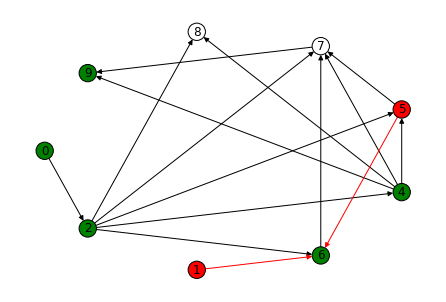

In [480]:
print(x, "_|_", y, "|", z, ":", nx.algorithms.d_separated(D, set(x), set(y), set(z)))
plotGraphWithUnblockedPaths(D,x,y,z)

In [481]:
is_dsep_by_removing_at_most_k_nodes (D, x, y, z, k=2)

True

In [482]:
is_dsep_by_adding_at_most_k_nodes (D, x, y, z, k=2)

False

## Level 4: Non-adjacent vertices in a large random graph

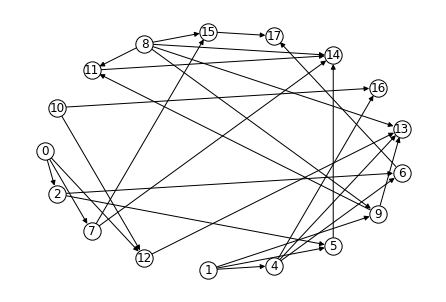

In [484]:
num_nodes = 18
D = generateRandomDAG(num_nodes, prob_edge=0.15)
nx.draw_shell(D, with_labels=True, node_color='w', edgecolors ='black')

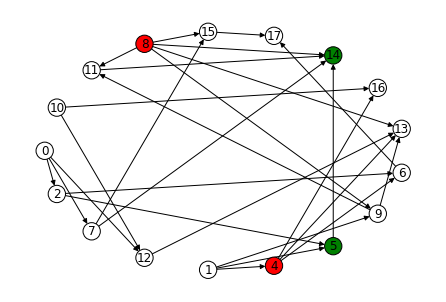

In [485]:
x = [np.random.randint(num_nodes)]

non_adj_nodes = list(range(num_nodes))
for (u,v) in D.edges():
    if u == x[0] or v == x[0]:
        if u in non_adj_nodes:
            non_adj_nodes.remove(u)
        if v in non_adj_nodes:
            non_adj_nodes.remove(v)
        
y = [np.random.choice(non_adj_nodes)]

possible_nodes = list(range(num_nodes))
possible_nodes.remove(x[0])
possible_nodes.remove(y[0])
cond_size = np.random.randint(num_nodes-2)
z = list(np.random.choice(possible_nodes, cond_size, replace=False))

plotGraphWithColors(D,x,y,z)

[8] _|_ [4] | [5, 14] : False


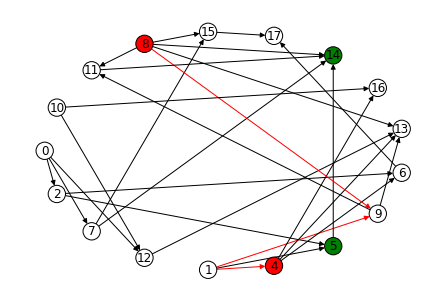

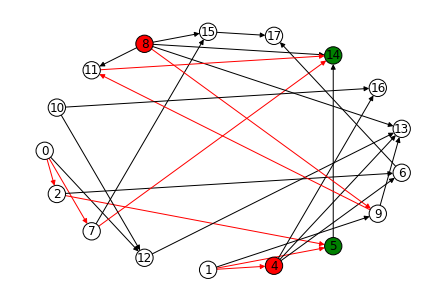

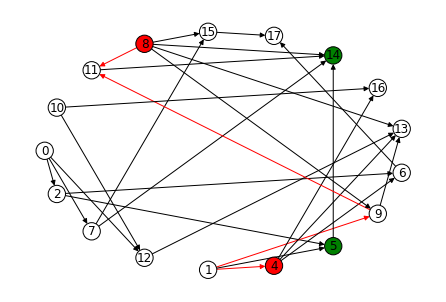

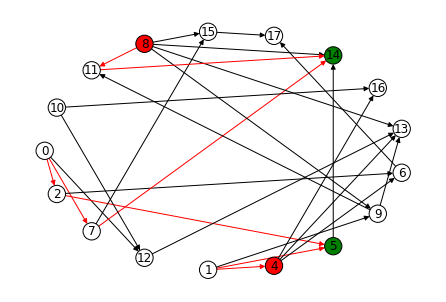

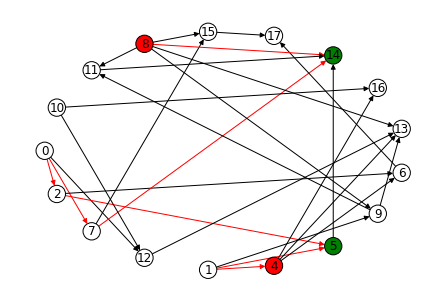

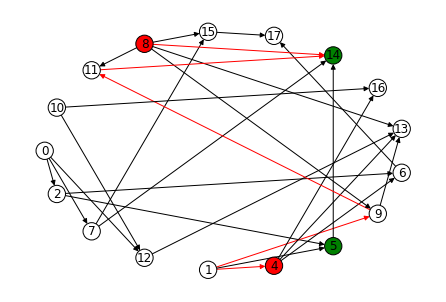

In [486]:
print(x, "_|_", y, "|", z, ":", nx.algorithms.d_separated(D, set(x), set(y), set(z)))
plotGraphWithUnblockedPaths(D,x,y,z)

In [487]:
is_dsep_by_removing_at_most_k_nodes (D, x, y, z, k=1)

True

In [488]:
is_dsep_by_adding_at_most_k_nodes (D, x, y, z, k=1)

True